# Calibration of SGLD hyperparameters for MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/sgld_calibration.ipynb)

**This notebook takes a while to run, and therefore is not intended to be run as part of the demo.**

This notebook walks through the process for calibrating hyperparameters for Stochastic Gradient Langevin Dynamics (SGLD) based LLC (or $\hat\lambda$) estimation. The model we'll use is a small 2-layer ReLU network (~1M params) trained on the MNIST dataset.

Note that in this case, the theoretical value of the LLC is not known. The intent of this notebook is to demonstrate that, even when we don't have access to the ground truth $\lambda$, there are diagnostic processes that can allow us to be more confident that $\hat\lambda$ preserves desirable properties of $\lambda$, such as maintaining relative ordering of degeneracy. This also reflects most real-world situations where we're interested in $\hat\lambda$ estimations.

Finally, we should emphasize that this is more an art than a science. There is still a great deal of uncertainty and many unknown unknowns. The process of LLC estimation is a **work in progress**, and this notebook only reflects the best state of our knowledge at the time of the creation of this notebook.

This notebook is split into 5 sections:
1. Data preparation
2. Training model checkpoints
3. Running calibration sweep
4. Plotting LLC estimations over time
5. Selecting $\epsilon$ and $\gamma$

In [3]:
%pip install devinterp torchvision

Note: you may need to restart the kernel to use updated packages.


In [102]:
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.llc import estimate_learning_coeff_with_summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CHAINS = 8
NUM_DRAWS = 2000

plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

In [103]:
# Define the neural network
class MNIST(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(MNIST, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Train/test utils
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

### 1. Data preparation

In [104]:
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = MNIST().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 200

60000


### 2. Training model checkpoints

In [89]:
# train model
train_losses = []
test_losses = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 118/118 [00:02<00:00, 47.72it/s]


Epoch 1, Train Loss: 1.95011276915922, Test Loss: 1.1989634871482848


100%|██████████| 118/118 [00:02<00:00, 49.06it/s]


Epoch 2, Train Loss: 0.736962079749269, Test Loss: 0.4984272852540016


100%|██████████| 118/118 [00:02<00:00, 47.25it/s]


Epoch 3, Train Loss: 0.4469994192911407, Test Loss: 0.388454706966877


100%|██████████| 118/118 [00:02<00:00, 42.01it/s]


Epoch 4, Train Loss: 0.37443506187301573, Test Loss: 0.3417148858308792


100%|██████████| 118/118 [00:02<00:00, 50.71it/s]


Epoch 5, Train Loss: 0.3385547697544098, Test Loss: 0.31989716589450834


100%|██████████| 118/118 [00:02<00:00, 48.55it/s]


Epoch 6, Train Loss: 0.3168589595263287, Test Loss: 0.29764694198966024


100%|██████████| 118/118 [00:02<00:00, 49.76it/s]


Epoch 7, Train Loss: 0.297584653784663, Test Loss: 0.2849042765796185


100%|██████████| 118/118 [00:02<00:00, 50.56it/s]


Epoch 8, Train Loss: 0.2815710594088344, Test Loss: 0.2708530452102423


100%|██████████| 118/118 [00:02<00:00, 50.45it/s]


Epoch 9, Train Loss: 0.2689905635128587, Test Loss: 0.2596100404858589


100%|██████████| 118/118 [00:02<00:00, 49.47it/s]


Epoch 10, Train Loss: 0.25742819059198185, Test Loss: 0.24919653981924056


100%|██████████| 118/118 [00:02<00:00, 50.90it/s]


Epoch 11, Train Loss: 0.2463935683086767, Test Loss: 0.2403705645352602


100%|██████████| 118/118 [00:02<00:00, 50.29it/s]


Epoch 12, Train Loss: 0.23670608967037524, Test Loss: 0.23328397311270238


100%|██████████| 118/118 [00:02<00:00, 49.56it/s]


Epoch 13, Train Loss: 0.22726620733737946, Test Loss: 0.22186431027948855


100%|██████████| 118/118 [00:02<00:00, 48.97it/s]


Epoch 14, Train Loss: 0.21839630856352338, Test Loss: 0.21554758362472057


100%|██████████| 118/118 [00:02<00:00, 49.19it/s]


Epoch 15, Train Loss: 0.20967073321847593, Test Loss: 0.20644639879465104


100%|██████████| 118/118 [00:02<00:00, 52.13it/s]


Epoch 16, Train Loss: 0.2023608479964531, Test Loss: 0.19968271292746068


100%|██████████| 118/118 [00:02<00:00, 52.45it/s]


Epoch 17, Train Loss: 0.19404580886081113, Test Loss: 0.1927823696285486


100%|██████████| 118/118 [00:02<00:00, 52.01it/s]


Epoch 18, Train Loss: 0.18569533208037836, Test Loss: 0.1877077419310808


100%|██████████| 118/118 [00:02<00:00, 52.69it/s]


Epoch 19, Train Loss: 0.180758220980228, Test Loss: 0.1800538171082735


100%|██████████| 118/118 [00:02<00:00, 47.59it/s]


Epoch 20, Train Loss: 0.1740743432635978, Test Loss: 0.1749073151499033


100%|██████████| 118/118 [00:02<00:00, 51.36it/s]


Epoch 21, Train Loss: 0.16828586824112018, Test Loss: 0.16781539730727674


100%|██████████| 118/118 [00:02<00:00, 52.26it/s]


Epoch 22, Train Loss: 0.16312208853788296, Test Loss: 0.16480815187096595


100%|██████████| 118/118 [00:02<00:00, 49.50it/s]


Epoch 23, Train Loss: 0.1567008297069598, Test Loss: 0.15920317731797695


100%|██████████| 118/118 [00:02<00:00, 47.76it/s]


Epoch 24, Train Loss: 0.15081795027195397, Test Loss: 0.15641536116600036


100%|██████████| 118/118 [00:02<00:00, 52.38it/s]


Epoch 25, Train Loss: 0.14630579740061597, Test Loss: 0.15182673633098603


100%|██████████| 118/118 [00:02<00:00, 53.68it/s]


Epoch 26, Train Loss: 0.14167250440282336, Test Loss: 0.14635043144226073


100%|██████████| 118/118 [00:02<00:00, 52.27it/s]


Epoch 27, Train Loss: 0.13694785743699237, Test Loss: 0.14252626691013576


100%|██████████| 118/118 [00:02<00:00, 54.53it/s]


Epoch 28, Train Loss: 0.13245905436954256, Test Loss: 0.14042853470891714


100%|██████████| 118/118 [00:02<00:00, 54.37it/s]


Epoch 29, Train Loss: 0.12885295252426196, Test Loss: 0.13761740736663342


100%|██████████| 118/118 [00:02<00:00, 53.93it/s]


Epoch 30, Train Loss: 0.12553206142985215, Test Loss: 0.1329550851136446


100%|██████████| 118/118 [00:02<00:00, 44.21it/s]


Epoch 31, Train Loss: 0.12196360465328572, Test Loss: 0.12960963789373636


100%|██████████| 118/118 [00:02<00:00, 49.90it/s]


Epoch 32, Train Loss: 0.11745572607901136, Test Loss: 0.12657750975340604


100%|██████████| 118/118 [00:02<00:00, 48.73it/s]


Epoch 33, Train Loss: 0.11391157123370696, Test Loss: 0.12497025802731514


100%|██████████| 118/118 [00:02<00:00, 53.15it/s]


Epoch 34, Train Loss: 0.1112009400217715, Test Loss: 0.12081620786339045


100%|██████████| 118/118 [00:02<00:00, 53.65it/s]


Epoch 35, Train Loss: 0.10846766851589841, Test Loss: 0.1183786449022591


100%|██████████| 118/118 [00:02<00:00, 52.89it/s]


Epoch 36, Train Loss: 0.10451741131432986, Test Loss: 0.1159822503104806


100%|██████████| 118/118 [00:02<00:00, 53.83it/s]


Epoch 37, Train Loss: 0.10275741590786788, Test Loss: 0.11402907837182283


100%|██████████| 118/118 [00:02<00:00, 53.16it/s]


Epoch 38, Train Loss: 0.09889434776821379, Test Loss: 0.11450510006397963


100%|██████████| 118/118 [00:02<00:00, 52.99it/s]


Epoch 39, Train Loss: 0.09653471681778714, Test Loss: 0.11025191126391291


100%|██████████| 118/118 [00:02<00:00, 54.75it/s]


Epoch 40, Train Loss: 0.09425091001568205, Test Loss: 0.10796507252380252


100%|██████████| 118/118 [00:02<00:00, 54.60it/s]


Epoch 41, Train Loss: 0.09151189647993799, Test Loss: 0.10574936475604772


100%|██████████| 118/118 [00:02<00:00, 52.53it/s]


Epoch 42, Train Loss: 0.09016943315707021, Test Loss: 0.10413270378485322


100%|██████████| 118/118 [00:02<00:00, 55.08it/s]


Epoch 43, Train Loss: 0.0869949830980119, Test Loss: 0.10346688264980912


100%|██████████| 118/118 [00:02<00:00, 52.70it/s]


Epoch 44, Train Loss: 0.0847844634583946, Test Loss: 0.10072023496031761


100%|██████████| 118/118 [00:02<00:00, 49.90it/s]


Epoch 45, Train Loss: 0.08232151821129403, Test Loss: 0.10009038057178259


100%|██████████| 118/118 [00:02<00:00, 49.35it/s]


Epoch 46, Train Loss: 0.08012057705072023, Test Loss: 0.09885455332696438


100%|██████████| 118/118 [00:02<00:00, 48.24it/s]


Epoch 47, Train Loss: 0.07825589309430729, Test Loss: 0.09793285513296723


100%|██████████| 118/118 [00:02<00:00, 41.78it/s]


Epoch 48, Train Loss: 0.07635836877812774, Test Loss: 0.0955151298083365


100%|██████████| 118/118 [00:02<00:00, 50.40it/s]


Epoch 49, Train Loss: 0.07450650130414356, Test Loss: 0.09527538418769836


100%|██████████| 118/118 [00:02<00:00, 48.30it/s]


Epoch 50, Train Loss: 0.07265224462469756, Test Loss: 0.09332312587648631


100%|██████████| 118/118 [00:02<00:00, 53.83it/s]


Epoch 51, Train Loss: 0.07049430791541177, Test Loss: 0.09113525208085775


100%|██████████| 118/118 [00:02<00:00, 42.11it/s]


Epoch 52, Train Loss: 0.06887866774479211, Test Loss: 0.0912831106223166


100%|██████████| 118/118 [00:02<00:00, 48.39it/s]


Epoch 53, Train Loss: 0.06782001894661936, Test Loss: 0.088799849152565


100%|██████████| 118/118 [00:02<00:00, 54.59it/s]


Epoch 54, Train Loss: 0.06619454326771074, Test Loss: 0.08796557113528251


100%|██████████| 118/118 [00:02<00:00, 52.38it/s]


Epoch 55, Train Loss: 0.06441226197501361, Test Loss: 0.08705908730626107


100%|██████████| 118/118 [00:02<00:00, 52.65it/s]


Epoch 56, Train Loss: 0.06324701740453809, Test Loss: 0.0859617430716753


100%|██████████| 118/118 [00:02<00:00, 50.73it/s]


Epoch 57, Train Loss: 0.06145840393916025, Test Loss: 0.08397798128426075


100%|██████████| 118/118 [00:02<00:00, 52.67it/s]


Epoch 58, Train Loss: 0.05986141040921211, Test Loss: 0.08730422537773848


100%|██████████| 118/118 [00:02<00:00, 53.77it/s]


Epoch 59, Train Loss: 0.058734339393549044, Test Loss: 0.08400449426844717


100%|██████████| 118/118 [00:02<00:00, 52.55it/s]


Epoch 60, Train Loss: 0.05726753487804179, Test Loss: 0.0827803929336369


100%|██████████| 118/118 [00:02<00:00, 48.78it/s]


Epoch 61, Train Loss: 0.05615296942513373, Test Loss: 0.08188272081315517


100%|██████████| 118/118 [00:02<00:00, 51.98it/s]


Epoch 62, Train Loss: 0.05501302721578691, Test Loss: 0.08145459070801735


100%|██████████| 118/118 [00:02<00:00, 53.44it/s]


Epoch 63, Train Loss: 0.05435189636329473, Test Loss: 0.08084196085110307


100%|██████████| 118/118 [00:02<00:00, 52.94it/s]


Epoch 64, Train Loss: 0.05249820172912994, Test Loss: 0.07939339121803642


100%|██████████| 118/118 [00:02<00:00, 52.42it/s]


Epoch 65, Train Loss: 0.05115572672526715, Test Loss: 0.07994109280407428


100%|██████████| 118/118 [00:02<00:00, 55.49it/s]


Epoch 66, Train Loss: 0.05001802063720711, Test Loss: 0.08001258526928723


100%|██████████| 118/118 [00:02<00:00, 55.26it/s]


Epoch 67, Train Loss: 0.04900381886163505, Test Loss: 0.07773434398695826


100%|██████████| 118/118 [00:02<00:00, 56.14it/s]


Epoch 68, Train Loss: 0.04798951074165308, Test Loss: 0.07674539601430297


100%|██████████| 118/118 [00:02<00:00, 55.72it/s]


Epoch 69, Train Loss: 0.047169435753534404, Test Loss: 0.07624773536808789


100%|██████████| 118/118 [00:02<00:00, 55.69it/s]


Epoch 70, Train Loss: 0.0458632639088368, Test Loss: 0.07652347157709301


100%|██████████| 118/118 [00:02<00:00, 54.03it/s]


Epoch 71, Train Loss: 0.04481490832453562, Test Loss: 0.07596820029430092


100%|██████████| 118/118 [00:02<00:00, 53.05it/s]


Epoch 72, Train Loss: 0.04406364835104195, Test Loss: 0.07536602448672056


100%|██████████| 118/118 [00:02<00:00, 52.92it/s]


Epoch 73, Train Loss: 0.04311198946404255, Test Loss: 0.07387233735062182


100%|██████████| 118/118 [00:02<00:00, 45.11it/s]


Epoch 74, Train Loss: 0.04188742927449234, Test Loss: 0.07409821241162717


100%|██████████| 118/118 [00:02<00:00, 50.52it/s]


Epoch 75, Train Loss: 0.0413823656074829, Test Loss: 0.07379701980389655


100%|██████████| 118/118 [00:02<00:00, 52.26it/s]


Epoch 76, Train Loss: 0.04030405919430619, Test Loss: 0.07373528820462524


100%|██████████| 118/118 [00:02<00:00, 54.60it/s]


Epoch 77, Train Loss: 0.039426306325752856, Test Loss: 0.07231593490578234


100%|██████████| 118/118 [00:02<00:00, 54.69it/s]


Epoch 78, Train Loss: 0.038956900285083355, Test Loss: 0.07239450635388493


100%|██████████| 118/118 [00:02<00:00, 55.14it/s]


Epoch 79, Train Loss: 0.037942408434099566, Test Loss: 0.07152157677337527


100%|██████████| 118/118 [00:02<00:00, 54.98it/s]


Epoch 80, Train Loss: 0.03708378242928598, Test Loss: 0.0715971798170358


100%|██████████| 118/118 [00:02<00:00, 54.11it/s]


Epoch 81, Train Loss: 0.03647203416705637, Test Loss: 0.07138169002719223


100%|██████████| 118/118 [00:02<00:00, 55.72it/s]


Epoch 82, Train Loss: 0.035743016757513, Test Loss: 0.07058968846686184


100%|██████████| 118/118 [00:02<00:00, 55.56it/s]


Epoch 83, Train Loss: 0.0353209738919543, Test Loss: 0.07030593957751989


100%|██████████| 118/118 [00:02<00:00, 54.73it/s]


Epoch 84, Train Loss: 0.03436170755175211, Test Loss: 0.06963748200796545


100%|██████████| 118/118 [00:02<00:00, 53.58it/s]


Epoch 85, Train Loss: 0.033823178236577975, Test Loss: 0.07021407918073237


100%|██████████| 118/118 [00:02<00:00, 54.79it/s]


Epoch 86, Train Loss: 0.033072652910851826, Test Loss: 0.06951381368562579


100%|██████████| 118/118 [00:02<00:00, 55.99it/s]


Epoch 87, Train Loss: 0.032274297241247814, Test Loss: 0.06887688292190433


100%|██████████| 118/118 [00:02<00:00, 55.42it/s]


Epoch 88, Train Loss: 0.031845152362297145, Test Loss: 0.06929390239529312


100%|██████████| 118/118 [00:02<00:00, 56.01it/s]


Epoch 89, Train Loss: 0.031123909546788467, Test Loss: 0.06816094424575567


100%|██████████| 118/118 [00:02<00:00, 54.41it/s]


Epoch 90, Train Loss: 0.03042106322502181, Test Loss: 0.06899979035370052


100%|██████████| 118/118 [00:02<00:00, 55.44it/s]


Epoch 91, Train Loss: 0.029719266677433152, Test Loss: 0.06861964710988104


100%|██████████| 118/118 [00:02<00:00, 56.11it/s]


Epoch 92, Train Loss: 0.02929666083527066, Test Loss: 0.0676287959329784


100%|██████████| 118/118 [00:02<00:00, 54.84it/s]


Epoch 93, Train Loss: 0.02867318724550433, Test Loss: 0.0676027269102633


100%|██████████| 118/118 [00:02<00:00, 55.27it/s]


Epoch 94, Train Loss: 0.028109516703792043, Test Loss: 0.06935413498431445


100%|██████████| 118/118 [00:02<00:00, 54.17it/s]


Epoch 95, Train Loss: 0.027587464110831083, Test Loss: 0.06742297457531095


100%|██████████| 118/118 [00:02<00:00, 54.66it/s]


Epoch 96, Train Loss: 0.026916546332728813, Test Loss: 0.06737883407622576


100%|██████████| 118/118 [00:02<00:00, 55.42it/s]


Epoch 97, Train Loss: 0.026344239443414293, Test Loss: 0.0667676438111812


100%|██████████| 118/118 [00:02<00:00, 53.83it/s]


Epoch 98, Train Loss: 0.025944204543227867, Test Loss: 0.06673948084935546


100%|██████████| 118/118 [00:02<00:00, 53.54it/s]


Epoch 99, Train Loss: 0.026087266314080208, Test Loss: 0.06632600044831634


100%|██████████| 118/118 [00:02<00:00, 49.01it/s]


Epoch 100, Train Loss: 0.025133263951135895, Test Loss: 0.06687933318316937


100%|██████████| 118/118 [00:02<00:00, 56.12it/s]


Epoch 101, Train Loss: 0.024662891608047282, Test Loss: 0.06622779462486506


100%|██████████| 118/118 [00:02<00:00, 53.24it/s]


Epoch 102, Train Loss: 0.024006821972838904, Test Loss: 0.06687236544676126


100%|██████████| 118/118 [00:02<00:00, 55.10it/s]


Epoch 103, Train Loss: 0.02361119464355505, Test Loss: 0.06621339106932282


100%|██████████| 118/118 [00:02<00:00, 54.56it/s]


Epoch 104, Train Loss: 0.02308816443813049, Test Loss: 0.06609862786717713


100%|██████████| 118/118 [00:02<00:00, 56.65it/s]


Epoch 105, Train Loss: 0.022662753602331977, Test Loss: 0.06622585686855018


100%|██████████| 118/118 [00:02<00:00, 56.73it/s]


Epoch 106, Train Loss: 0.02219281041742129, Test Loss: 0.06611895388923586


100%|██████████| 118/118 [00:02<00:00, 56.28it/s]


Epoch 107, Train Loss: 0.022064340119329045, Test Loss: 0.06570954769849777


100%|██████████| 118/118 [00:02<00:00, 54.95it/s]


Epoch 108, Train Loss: 0.02153151123232003, Test Loss: 0.06626500375568867


100%|██████████| 118/118 [00:02<00:00, 53.03it/s]


Epoch 109, Train Loss: 0.021042843294030025, Test Loss: 0.06528136525303126


100%|██████████| 118/118 [00:02<00:00, 55.16it/s]


Epoch 110, Train Loss: 0.0205805169150107, Test Loss: 0.0656333688646555


100%|██████████| 118/118 [00:02<00:00, 55.83it/s]


Epoch 111, Train Loss: 0.02031639665838773, Test Loss: 0.06625926084816455


100%|██████████| 118/118 [00:02<00:00, 57.34it/s]


Epoch 112, Train Loss: 0.019906069878173078, Test Loss: 0.06459765955805778


100%|██████████| 118/118 [00:02<00:00, 56.93it/s]


Epoch 113, Train Loss: 0.01956532797697237, Test Loss: 0.0648739644791931


100%|██████████| 118/118 [00:02<00:00, 56.71it/s]


Epoch 114, Train Loss: 0.019230087453467867, Test Loss: 0.06498220628127456


100%|██████████| 118/118 [00:02<00:00, 55.97it/s]


Epoch 115, Train Loss: 0.01879380000913042, Test Loss: 0.06537893391214311


100%|██████████| 118/118 [00:02<00:00, 56.67it/s]


Epoch 116, Train Loss: 0.018563017122826334, Test Loss: 0.06479697171598672


100%|██████████| 118/118 [00:02<00:00, 56.53it/s]


Epoch 117, Train Loss: 0.01825409845875229, Test Loss: 0.06474623465910553


100%|██████████| 118/118 [00:02<00:00, 57.01it/s]


Epoch 118, Train Loss: 0.017990417557500176, Test Loss: 0.06482186140492559


100%|██████████| 118/118 [00:02<00:00, 54.24it/s]


Epoch 119, Train Loss: 0.017689308151602745, Test Loss: 0.06437424886971713


100%|██████████| 118/118 [00:02<00:00, 54.29it/s]


Epoch 120, Train Loss: 0.017333208709576373, Test Loss: 0.064343047933653


100%|██████████| 118/118 [00:02<00:00, 55.42it/s]


Epoch 121, Train Loss: 0.016916087907502205, Test Loss: 0.06506044156849385


100%|██████████| 118/118 [00:02<00:00, 53.69it/s]


Epoch 122, Train Loss: 0.016724613921369536, Test Loss: 0.06417038571089506


100%|██████████| 118/118 [00:02<00:00, 56.86it/s]


Epoch 123, Train Loss: 0.016702372920146938, Test Loss: 0.06453486257232725


100%|██████████| 118/118 [00:02<00:00, 54.01it/s]


Epoch 124, Train Loss: 0.01616766027932576, Test Loss: 0.06465850537642837


100%|██████████| 118/118 [00:02<00:00, 55.86it/s]


Epoch 125, Train Loss: 0.015749614204327436, Test Loss: 0.06456193863414228


100%|██████████| 118/118 [00:02<00:00, 56.30it/s]


Epoch 126, Train Loss: 0.015492595657232707, Test Loss: 0.06558677479624749


100%|██████████| 118/118 [00:02<00:00, 57.17it/s]


Epoch 127, Train Loss: 0.015359076513451034, Test Loss: 0.06411431725136936


100%|██████████| 118/118 [00:02<00:00, 57.14it/s]


Epoch 128, Train Loss: 0.01496486229253775, Test Loss: 0.06453347415663302


100%|██████████| 118/118 [00:02<00:00, 56.13it/s]


Epoch 129, Train Loss: 0.014770178514990514, Test Loss: 0.06423282120376825


100%|██████████| 118/118 [00:02<00:00, 56.16it/s]


Epoch 130, Train Loss: 0.01481669657800536, Test Loss: 0.06460567712783813


100%|██████████| 118/118 [00:02<00:00, 55.27it/s]


Epoch 131, Train Loss: 0.014389078401155391, Test Loss: 0.06454972391948104


100%|██████████| 118/118 [00:02<00:00, 51.92it/s]


Epoch 132, Train Loss: 0.013998241408459716, Test Loss: 0.06483401120640338


100%|██████████| 118/118 [00:02<00:00, 57.03it/s]


Epoch 133, Train Loss: 0.013729413880540406, Test Loss: 0.06464172070845961


100%|██████████| 118/118 [00:02<00:00, 57.05it/s]


Epoch 134, Train Loss: 0.013487439981456531, Test Loss: 0.06497586378827691


100%|██████████| 118/118 [00:02<00:00, 56.84it/s]


Epoch 135, Train Loss: 0.013318144763677807, Test Loss: 0.06427630009129644


100%|██████████| 118/118 [00:02<00:00, 57.38it/s]


Epoch 136, Train Loss: 0.013009462205661555, Test Loss: 0.0641660806722939


100%|██████████| 118/118 [00:02<00:00, 57.01it/s]


Epoch 137, Train Loss: 0.012868263778450378, Test Loss: 0.06471104733645916


100%|██████████| 118/118 [00:02<00:00, 54.39it/s]


Epoch 138, Train Loss: 0.012613227251538281, Test Loss: 0.06435909727588296


100%|██████████| 118/118 [00:02<00:00, 56.87it/s]


Epoch 139, Train Loss: 0.012596611379472128, Test Loss: 0.06447425526566804


100%|██████████| 118/118 [00:02<00:00, 56.52it/s]


Epoch 140, Train Loss: 0.012229937992958446, Test Loss: 0.06473470600321889


100%|██████████| 118/118 [00:02<00:00, 55.70it/s]


Epoch 141, Train Loss: 0.012000835950533717, Test Loss: 0.06422779206186532


100%|██████████| 118/118 [00:02<00:00, 54.91it/s]


Epoch 142, Train Loss: 0.011942134159853903, Test Loss: 0.06453262404538691


100%|██████████| 118/118 [00:02<00:00, 55.25it/s]


Epoch 143, Train Loss: 0.011651063914079282, Test Loss: 0.06463482133112848


100%|██████████| 118/118 [00:02<00:00, 55.87it/s]


Epoch 144, Train Loss: 0.01143375363090407, Test Loss: 0.06513009299524128


100%|██████████| 118/118 [00:02<00:00, 56.40it/s]


Epoch 145, Train Loss: 0.01126916263789191, Test Loss: 0.06445728898979723


100%|██████████| 118/118 [00:02<00:00, 54.96it/s]


Epoch 146, Train Loss: 0.01113724062945378, Test Loss: 0.06439522719010711


100%|██████████| 118/118 [00:02<00:00, 56.29it/s]


Epoch 147, Train Loss: 0.010990216388856456, Test Loss: 0.06439629280939699


100%|██████████| 118/118 [00:02<00:00, 50.28it/s]


Epoch 148, Train Loss: 0.01079346322438727, Test Loss: 0.0645018523093313


100%|██████████| 118/118 [00:02<00:00, 54.89it/s]


Epoch 149, Train Loss: 0.010556644507510177, Test Loss: 0.06530158123932779


100%|██████████| 118/118 [00:02<00:00, 54.94it/s]


Epoch 150, Train Loss: 0.010437066583909978, Test Loss: 0.06486112894490362


100%|██████████| 118/118 [00:02<00:00, 57.46it/s]


Epoch 151, Train Loss: 0.010268584509395946, Test Loss: 0.06460220436565578


100%|██████████| 118/118 [00:02<00:00, 57.70it/s]


Epoch 152, Train Loss: 0.010159996855151603, Test Loss: 0.0653307135682553


100%|██████████| 118/118 [00:02<00:00, 57.52it/s]


Epoch 153, Train Loss: 0.009971749582091126, Test Loss: 0.0642168668564409


100%|██████████| 118/118 [00:02<00:00, 56.94it/s]


Epoch 154, Train Loss: 0.009805064754939433, Test Loss: 0.06434946954250335


100%|██████████| 118/118 [00:02<00:00, 57.49it/s]


Epoch 155, Train Loss: 0.009723254949075439, Test Loss: 0.06507258382625877


100%|██████████| 118/118 [00:02<00:00, 57.73it/s]


Epoch 156, Train Loss: 0.009583277515356698, Test Loss: 0.06441776533611118


100%|██████████| 118/118 [00:02<00:00, 57.57it/s]


Epoch 157, Train Loss: 0.009381567416081236, Test Loss: 0.0646320388186723


100%|██████████| 118/118 [00:02<00:00, 56.49it/s]


Epoch 158, Train Loss: 0.009275742403973462, Test Loss: 0.06478628851473331


100%|██████████| 118/118 [00:02<00:00, 55.01it/s]


Epoch 159, Train Loss: 0.009108301729626827, Test Loss: 0.06483937613666058


100%|██████████| 118/118 [00:02<00:00, 56.76it/s]


Epoch 160, Train Loss: 0.008986450625204687, Test Loss: 0.06527614020742475


100%|██████████| 118/118 [00:02<00:00, 57.65it/s]


Epoch 161, Train Loss: 0.008809006628896094, Test Loss: 0.06465454678982496


100%|██████████| 118/118 [00:02<00:00, 57.71it/s]


Epoch 162, Train Loss: 0.008664530362555031, Test Loss: 0.06519681629724801


100%|██████████| 118/118 [00:02<00:00, 57.52it/s]


Epoch 163, Train Loss: 0.008602640717842822, Test Loss: 0.06519219116307795


100%|██████████| 118/118 [00:02<00:00, 57.51it/s]


Epoch 164, Train Loss: 0.008545878990474393, Test Loss: 0.06526601407676935


100%|██████████| 118/118 [00:02<00:00, 57.70it/s]


Epoch 165, Train Loss: 0.008323892374854472, Test Loss: 0.06507213795557618


100%|██████████| 118/118 [00:02<00:00, 57.57it/s]


Epoch 166, Train Loss: 0.00825050899411662, Test Loss: 0.06463780719786882


100%|██████████| 118/118 [00:02<00:00, 55.23it/s]


Epoch 167, Train Loss: 0.00811090471885972, Test Loss: 0.0654767940286547


100%|██████████| 118/118 [00:02<00:00, 57.18it/s]


Epoch 168, Train Loss: 0.007984705312745803, Test Loss: 0.06545958449132741


100%|██████████| 118/118 [00:02<00:00, 57.34it/s]


Epoch 169, Train Loss: 0.007917747805210746, Test Loss: 0.0652781213633716


100%|██████████| 118/118 [00:02<00:00, 53.53it/s]


Epoch 170, Train Loss: 0.0077725835795656355, Test Loss: 0.06534621235914528


100%|██████████| 118/118 [00:02<00:00, 56.83it/s]


Epoch 171, Train Loss: 0.007648107927229445, Test Loss: 0.06589688155800104


100%|██████████| 118/118 [00:02<00:00, 57.81it/s]


Epoch 172, Train Loss: 0.007582188870015917, Test Loss: 0.06575623555108905


100%|██████████| 118/118 [00:02<00:00, 57.95it/s]


Epoch 173, Train Loss: 0.007458263380705553, Test Loss: 0.06553532802499831


100%|██████████| 118/118 [00:02<00:00, 57.37it/s]


Epoch 174, Train Loss: 0.00735875081184115, Test Loss: 0.0651405042503029


100%|██████████| 118/118 [00:02<00:00, 57.79it/s]


Epoch 175, Train Loss: 0.007253060942136888, Test Loss: 0.06532801170833409


100%|██████████| 118/118 [00:02<00:00, 57.53it/s]


Epoch 176, Train Loss: 0.007135897030327785, Test Loss: 0.06561435461044311


100%|██████████| 118/118 [00:02<00:00, 52.78it/s]


Epoch 177, Train Loss: 0.007041357459610928, Test Loss: 0.06578961019404232


100%|██████████| 118/118 [00:02<00:00, 56.93it/s]


Epoch 178, Train Loss: 0.00699350345974504, Test Loss: 0.0659009815659374


100%|██████████| 118/118 [00:02<00:00, 57.05it/s]


Epoch 179, Train Loss: 0.006911336688987784, Test Loss: 0.06623213901184499


100%|██████████| 118/118 [00:02<00:00, 56.98it/s]


Epoch 180, Train Loss: 0.00678574807065839, Test Loss: 0.06600914923474192


100%|██████████| 118/118 [00:02<00:00, 56.27it/s]


Epoch 181, Train Loss: 0.006667378859720745, Test Loss: 0.06613634685054422


100%|██████████| 118/118 [00:02<00:00, 57.15it/s]


Epoch 182, Train Loss: 0.006589610372291152, Test Loss: 0.06580842304974795


100%|██████████| 118/118 [00:02<00:00, 57.77it/s]


Epoch 183, Train Loss: 0.006484997636338664, Test Loss: 0.06598558849655092


100%|██████████| 118/118 [00:02<00:00, 56.70it/s]


Epoch 184, Train Loss: 0.006448305724977942, Test Loss: 0.06601225207559765


100%|██████████| 118/118 [00:02<00:00, 57.06it/s]


Epoch 185, Train Loss: 0.006342347328535328, Test Loss: 0.06630666861310601


100%|██████████| 118/118 [00:02<00:00, 56.65it/s]


Epoch 186, Train Loss: 0.0062840992695320464, Test Loss: 0.06575384153984487


100%|██████████| 118/118 [00:02<00:00, 55.06it/s]


Epoch 187, Train Loss: 0.006183160642572379, Test Loss: 0.0658295144326985


100%|██████████| 118/118 [00:02<00:00, 57.67it/s]


Epoch 188, Train Loss: 0.00606632050742411, Test Loss: 0.06598505428992212


100%|██████████| 118/118 [00:02<00:00, 57.26it/s]


Epoch 189, Train Loss: 0.005992271367192142, Test Loss: 0.06631664014421404


100%|██████████| 118/118 [00:02<00:00, 57.28it/s]


Epoch 190, Train Loss: 0.005929107282515931, Test Loss: 0.06673913514241576


100%|██████████| 118/118 [00:02<00:00, 57.42it/s]


Epoch 191, Train Loss: 0.005879802370870138, Test Loss: 0.06675169677473605


100%|██████████| 118/118 [00:02<00:00, 57.42it/s]


Epoch 192, Train Loss: 0.005850940427774468, Test Loss: 0.06614511301741004


100%|██████████| 118/118 [00:02<00:00, 57.34it/s]


Epoch 193, Train Loss: 0.005768555999828218, Test Loss: 0.06655108518898487


100%|██████████| 118/118 [00:02<00:00, 56.71it/s]


Epoch 194, Train Loss: 0.005653505900211759, Test Loss: 0.06619867333211005


100%|██████████| 118/118 [00:02<00:00, 57.19it/s]


Epoch 195, Train Loss: 0.005607917670050036, Test Loss: 0.06690716301091015


100%|██████████| 118/118 [00:02<00:00, 54.16it/s]


Epoch 196, Train Loss: 0.005530253062577192, Test Loss: 0.06654356815852225


100%|██████████| 118/118 [00:02<00:00, 55.82it/s]


Epoch 197, Train Loss: 0.005443360638741593, Test Loss: 0.06637024250812829


100%|██████████| 118/118 [00:02<00:00, 50.01it/s]


Epoch 198, Train Loss: 0.005381121098900498, Test Loss: 0.06674422344658523


100%|██████████| 118/118 [00:02<00:00, 53.30it/s]


Epoch 199, Train Loss: 0.005290721443489636, Test Loss: 0.0665362136438489


100%|██████████| 118/118 [00:02<00:00, 57.10it/s]


Epoch 200, Train Loss: 0.005222199504437335, Test Loss: 0.06694006405305117


Plotting the train and test loss to show that training has converged:

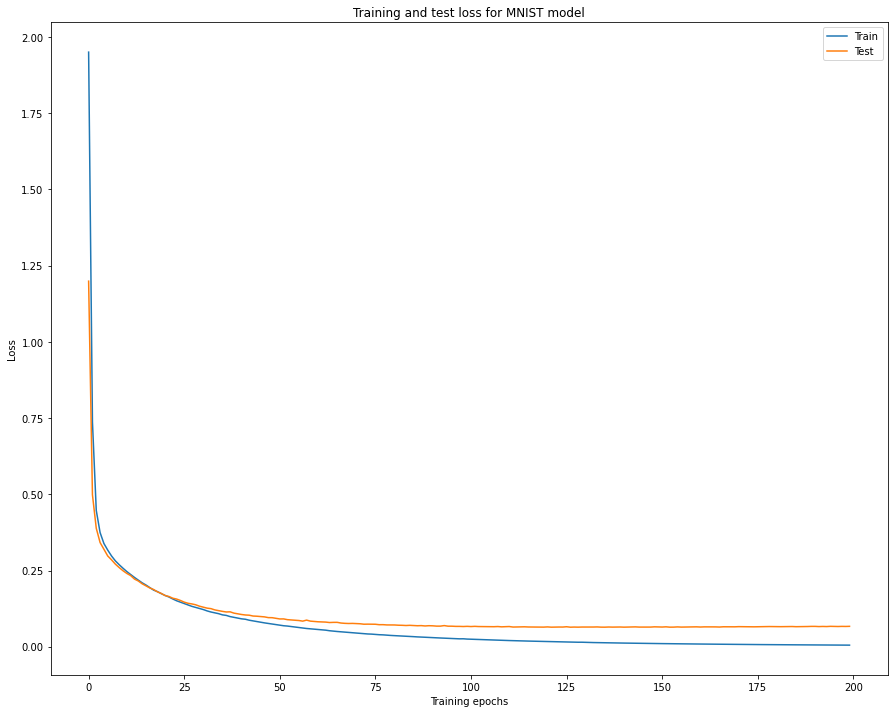

In [113]:
import matplotlib.pyplot as plt

epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Training and test loss for MNIST model')
plt.legend()
plt.show()

### 3. Running calibration sweep

The main idea is to sweep across orders of magnitude of learning rate (epsilon) and elasticity (gamma). We look at the mean of LLC estimations over time by looking at the average estimated LLC for each chain at a given time step. A reasonable starting point for sweeping is to use `[1e-5, 1e-4, 1e-3]` for epsilon values and `[1, 10, 100]` for gamma values.

In [130]:
EPSILONS = [1e-5, 1e-4, 1e-3]
GAMMAS = [1, 10, 100]


def estimate_llcs_sweeper(model, epsilons, gammas):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                elasticity=gamma,
                num_samples=len(train_data),
                temperature="adaptive",
            )
            pair = (epsilon, gamma)
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=train_loader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                device=DEVICE,
                online=True,
            )
    return results


def plot_single_graph(result, title=''):
    llc_color = 'teal'
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result['loss/trace']
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result['llc/means']
    stds = result['llc/stds']
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx() 
    axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
    axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel('SGLD time step')
    axs.set_ylabel('loss')
    axs2.set_ylabel('llc', color=llc_color)
    axs2.tick_params(axis='y', labelcolor=llc_color)
    axs.axhline(color='black', linestyle=':')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sweep_single_model(results, epsilons, gammas, **kwargs):
    llc_color = 'teal'
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            # plot loss traces
            loss_traces = result['loss/trace']
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result['llc/means']
            stds = result['llc/stds']
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx() 
            axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
            axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)
            
            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel('SGLD time step')
            axs[i, j].set_ylabel('loss')
            axs2.set_ylabel('llc', color=llc_color)
            axs2.tick_params(axis='y', labelcolor=llc_color)
    if kwargs['title']:
        fig.suptitle(kwargs['title'], fontsize=16)
    plt.tight_layout()
    plt.show()

In [106]:
results = estimate_llcs_sweeper(checkpoints[-1], EPSILONS, GAMMAS)

Chain 7: 100%|██████████| 2000/2000 [00:55<00:00, 35.88it/s]


### 4. Plotting LLC estimations over time

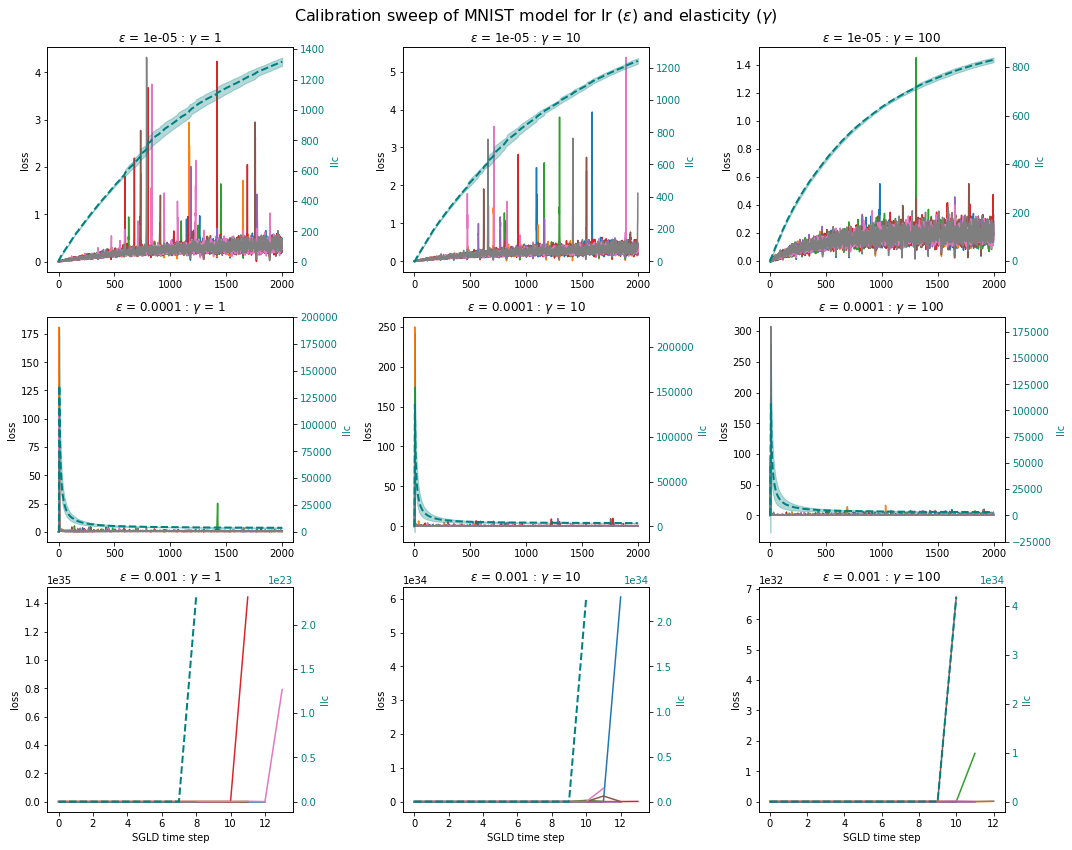

In [108]:
plot_sweep_single_model(results, EPSILONS, GAMMAS, title=r'Calibration sweep of MNIST model for lr ($\epsilon$) and elasticity ($\gamma$)')

In these graphs, the LLC estimation mean is shown as a teal dotted line, and the standard deviation is shown as a shaded teal area around the mean. The remaining lines are the loss trace for each estimation. These are plotted with a shared $y=0$ line and have different scales of y axis (which can be seen on the left and right sides of each subplot).

The major differences in this case seem to come from changes in $\epsilon$, or learning rate. Let's go row by row through what's happening.

1. In the first row, there's a curve that looks like it might converge, with the $\gamma=100$ case being the closest to flattening out. We can try re-running that case for longer to see if it does converge as expected. The loss traces also look healthy from a distance, but we can zoom in to check below.
2. The second row has a huge spike upwards in estimated LLC before quickly dropping back down and converging on a much smaller value. This is typically not a healthy sign, and we can see that the loss spikes up very high in each of these graphs first. We can take a closer look at one of these graphs below as well.
3. Finally, the third row has very few SGLD steps recorded on the x-axis. These LLC estimates are diverging quickly and become NaN values, which we definitely don't want to see. We probably don't need to investigate this row further, and we can assume that in general, $\epsilon=1e^{-3}$ values are too large for estimating LLC in this model.

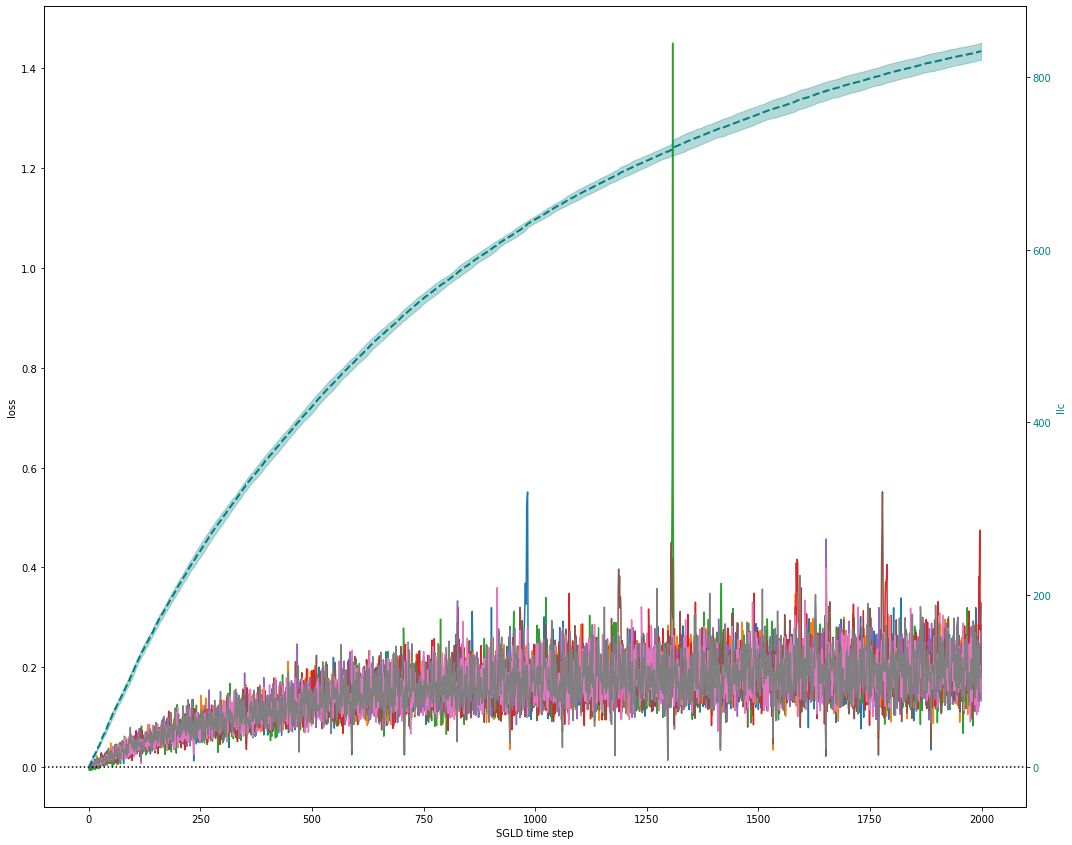

In [131]:
# Plotting a bigger version of the first row, third column graph above
epsilon = 1e-5
gamma = 100
result = results[(epsilon, gamma)]
plot_single_graph(result)

There are some occasional spikes in the loss trace, but in general the loss traces all gradually increase and then appear to flatten out, and they also appear to stay above 0. Except for the very tall green spike, this is essentially what we want a healthy loss trace to look like.

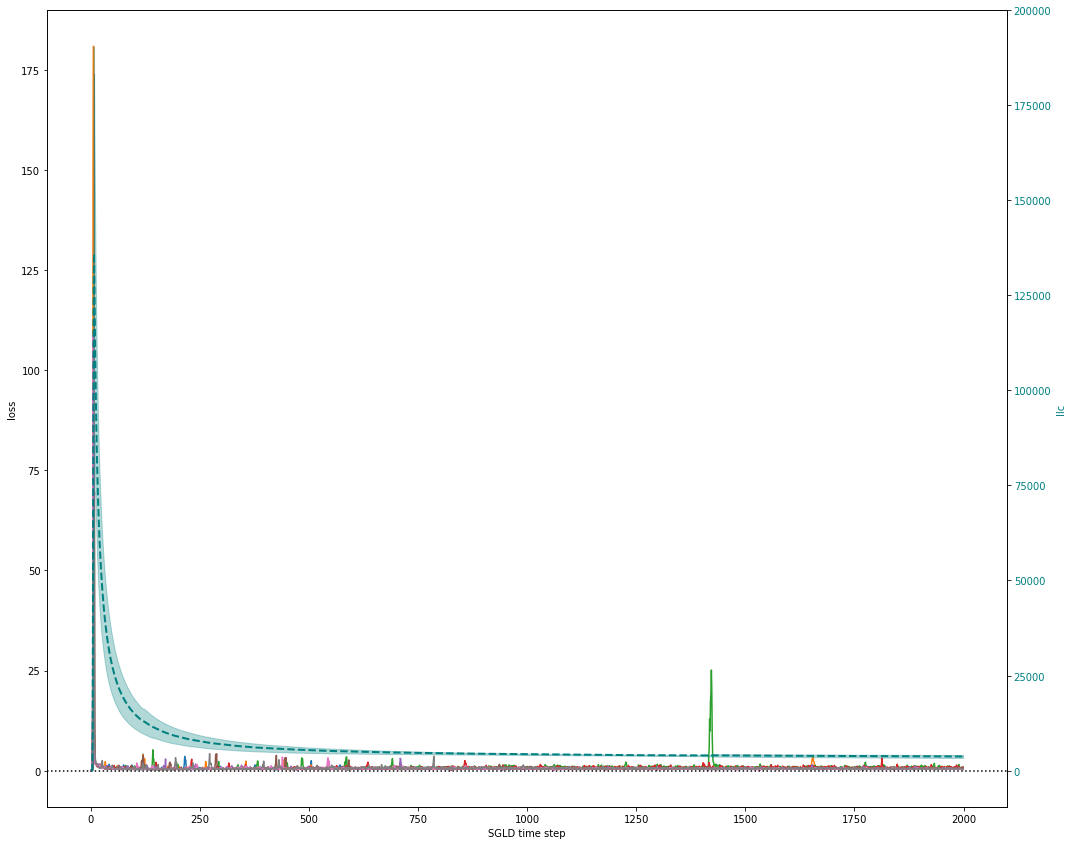

In [132]:
# Plotting a bigger version of the second row, first column graph above
epsilon = 1e-4
gamma = 1
result = results[(epsilon, gamma)]
plot_single_graph(result)

In this case, there's a huge spike at the very start of at least one (and maybe more than one) loss trace. In some models, this shape of LLC curve might happen because the SGLD sampling process is actually continuing to train the model, however in that case, we'd expect the loss traces to drop below the initial loss. In this example, the losses still remain positive after the initial spike, so it doesn't appear that SGLD is turning into continued training. It is currently unclear whether a spike (or in general, a not-monotonically-increasing curve) is a reason to invalidate a set of parameters, but it may be safest to consider it a yellow flag and pick a better set of parameters if possible.

**In general, the loss traces are a useful diagnostic tool and should be the first thing to check when there's odd behavior in your LLC estimation.**

Let's try running more samples on the $\epsilon=1e^{-5},\ \gamma=100$ case to see if it continues to flatten out.

In [133]:
optim_kwargs = dict(
    lr=1e-5,
    noise_level=1.0,
    elasticity=100,
    num_samples=len(train_data),
    temperature="adaptive",
)
result = estimate_learning_coeff_with_summary(
    model=checkpoints[-1],
    loader=train_loader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=optim_kwargs,
    num_chains=10,
    num_draws=5000,
    device=DEVICE,
    online=True,
)

Chain 9: 100%|██████████| 5000/5000 [02:16<00:00, 36.64it/s]


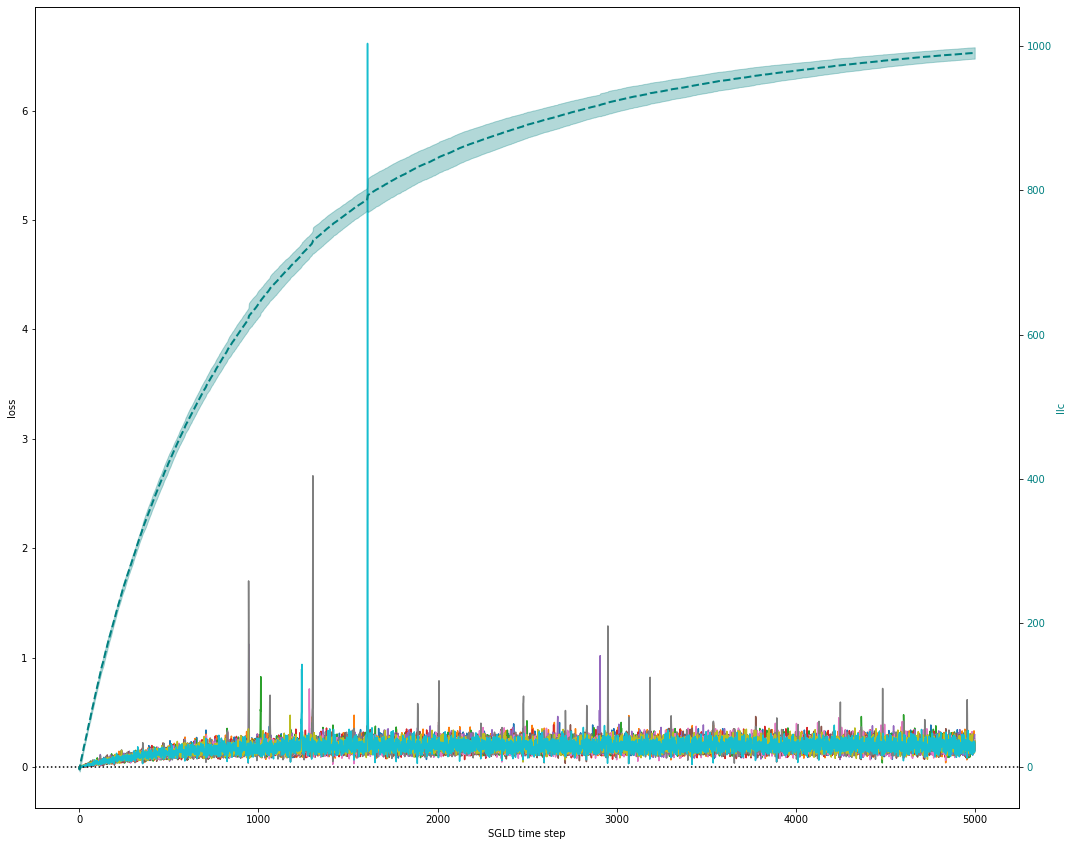

In [134]:
plot_single_graph(result)

### 5. Heuristics for selecting $\epsilon$ and $\gamma$

There is currently no One True Set of hyperparameters. Instead, the goal of calibration is to identify hyperparameters that maintain certain desirable properties. Some general such heuristics:
- Optimal traces should converge.
- Absolute $\hat\lambda$ estimates are not as important as relative $\hat\lambda$ estimates.
- The most important feature is that the relative ordering of estimates is maintained if you have different models to compare (e.g. different checkpoints).
- The graph should not have negative dips (or not dip negative for very long).
- You can also examine the loss traces or other diagnostics to check that they look healthy, such as in the examples above.
  - A good set of loss traces should stay above the initial loss value (or at least not drop below it too far or for too many steps) and should not diverge away from the initial loss value.

If you don't get good results on the first sweep, you might recenter your sweep and try again.

### 6. Selecting $\epsilon$ and $\gamma$ in this MNIST example

- The third row in our sweep graphs ($\epsilon=1e^{-3}$) is definitely a no-go, since the values quickly diverge to NaN.
- The second row has some odd behavior in the loss trace, causing a big spike in the initial LLC estimation. This should probably be avoided if there's a better option.
- With enough draws, the LLC estimation for $\epsilon=1e^{-5}, \ \gamma=100$ looks like it will converge nicely. The loss traces are basically flattened out as well, which is another indication that the LLC estimation should continue to converge without issue. In this first sweep, this would be my recommendation for hyperparameters, perhaps with even more draws if compute resources allow it.
- If more refinement is needed (e.g. it's necessary for LLC estimation to converge in a fewer number of draws), then another option would be to sweep with more granular values (say, a half order of magnitude) around $\epsilon=1e^{-5}, \ \gamma=100$